In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=2)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [2]:
#parameters for visualization
opts={'size':14, 'node_border':False, 'node_size':200, 'font_size':9, 'vertex_alpha':0.6,'title_key':'id'}

from eden.util.display import draw_graph, serialize_graph
import itertools
def plot(graphs, num=3, file_name=None, opts=None):    
    graphs = itertools.islice(graphs,num)
    for i,graph in enumerate(graphs): 
        if file_name is not None:
            draw_graph(graph, file_name=file_name+str(i)+'.png', **opts)
        else:
            draw_graph(graph, **opts)

In [3]:
#code for making artificial dataset
import random
def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,p=0.5):
    seq=''
    for c in seed:
        if random.random() < p: c = random.choice(alphabet_list)
        seq += c
    return seq

def make_artificial_dataset(alphabet='ACGU', motives=None, motif_length=6, sequence_length=100, n_sequences=1000, n_motives=1, p=0.2):
    alphabet_list=[c for c in alphabet]
    
    if motives is None:
        motives=[]
        for i in range(n_motives):
            motives.append(random_string(motif_length,alphabet_list))
    else:
        motif_length = len(motives[0])
        n_motives = len(motives)
        
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences / n_motives

    counter=0
    seqs=[]
    for i in range(n_seq_per_motif):
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,p)
            seq = left_flanking + noisy_motif + right_flanking
            seqs.append(('>ID%d'%counter,seq))
            counter += 1
    return motives, seqs

---

In [16]:
#setup parameters
alphabet='ACGU'
motif_length=10
motives=['A'*motif_length,'C'*motif_length,'G'*motif_length,'U'*motif_length]
sequence_length=80
n_sequences=300
p=0.01

#make dataset
MAKE_RANDOM_MOTIVES=False
if MAKE_RANDOM_MOTIVES:
    motives, seqs = make_artificial_dataset(alphabet=alphabet,motives=None, n_motives=4, motif_length=motif_length, sequence_length=sequence_length,n_sequences=n_sequences,p=p)
else:
    motives, seqs = make_artificial_dataset(alphabet=alphabet,motives=motives, sequence_length=sequence_length,n_sequences=n_sequences,p=p)
    
for motif in motives:
    print motif
    
for h, seq in seqs[:10]:
    print h
    print seq
print '...'
print '%d sequences' % len(seqs)

AAAAAAAAAA
CCCCCCCCCC
GGGGGGGGGG
UUUUUUUUUU
>ID0
AUUCCCGUAAUCUACGAUUAAGUCACAACCAAACCAAAAAAAAAAAUGGAUUACGGUCUGCGUUGGAAUCAGGGCCGUGC
>ID1
UGUAGUGCCGUAUUUGUGGCAUGAGCCCGGGCAAACCCCCCCCCCGUUUUCUGAAAUAAGCAAGACGCCCACCAAUGAGU
>ID2
UGAGCGCGACUUCUCUGCCAUAUUGAUUGGCCAGCGGGGGGGGGGAAGCCCUUAACUUCAGUUCUGCUAGAAUAUGUCCC
>ID3
UUCGUCGAACUGUCCUUAGAAUAAUCAAAGAUCUUUUUUUUUUUUCCCAGAAUCGCCAUUUAAGUGGGCGCAACUCGGUC
>ID4
AAAAGAAGCUCUAGUAUAUUUCAGUCUAUACUUUUAAAAAAAAAAGGACAGGCAUUGGUCCCCAGCGACAACUCCGAAGG
>ID5
UUCGAAGUAUUCGUCGGGUUUGACAGUAGGCGAGACCCCCCCCCCUUGCUUAUUGGCUUCUCACAUUAGCACAGAACAGG
>ID6
UGCUUGCCAUAGGUUUAGGCGCGACCCCUGCGCAAGGGGGGGGGGCGUUGUCUCGUCAGGCACCCUGGUGCGGGGCGGUU
>ID7
UCCAGGCCGAGUGCGGAAUCAUGCGGAGGUCGAGAUUUUUUUUUUUUCAUGUAUGCCUUAGAUCUGGCGAAGCUAGGCAC
>ID8
UGCUAGACCCAAUCGAGCGUUAUUCCGUCUUAUAAAAAAAAAAAAGACACUUAAUACAAAGGGUGCGUGAAUGCGGGACC
>ID9
AUUUAAUCCUAGCACGUAGAUAACGCAUUUCCAGCCCCCCCCCCCCUUGAGCUGUGGUUCACGACGAUGCCCCGGGAUCC
...
300 sequences


---

In [17]:
#identify motif region
start_1 = (sequence_length - motif_length)/2
end_1 = start_1 + motif_length
weight_1 = 10

context=20
#make a context zone
start_2 = start_1 - context
end_2 = end_1 + context
weight_2 = weight_1 / 3

background_weight=.1

start_end_weight_list = [(-1,-1,background_weight),(start_2,end_2,weight_2),(start_1,end_1,weight_1)]
listof_start_end_weight_list = [start_end_weight_list]*len(seqs)

In [29]:
%%time
from eden.struct_cluster import Transformer, StructCluster
transformer = Transformer(contraction_weight_scaling_factor=20)
struct_cluster = StructCluster(transformer=transformer)
struct_cluster.fit(seqs, listof_start_end_weight_list=listof_start_end_weight_list)

#instances:300  #features:8193
CPU times: user 31.4 s, sys: 2.57 s, total: 33.9 s
Wall time: 37.6 s


In [30]:
struct_cluster.set_params(distance_std_factor=1.5)
preds = struct_cluster.predict(seqs)
clustered_seqs = struct_cluster.clusters

eps: 1.081
cluster id: 0  num seqs: 8
cluster id: 1  num seqs: 7
cluster id: 2  num seqs: 5
cluster id: 3  num seqs: 8
cluster id: 4  num seqs: 6
cluster id: -1  num seqs: 266
num clusters: 5


cID: 0 [# 8]
--------------------------------------------------------------------------------


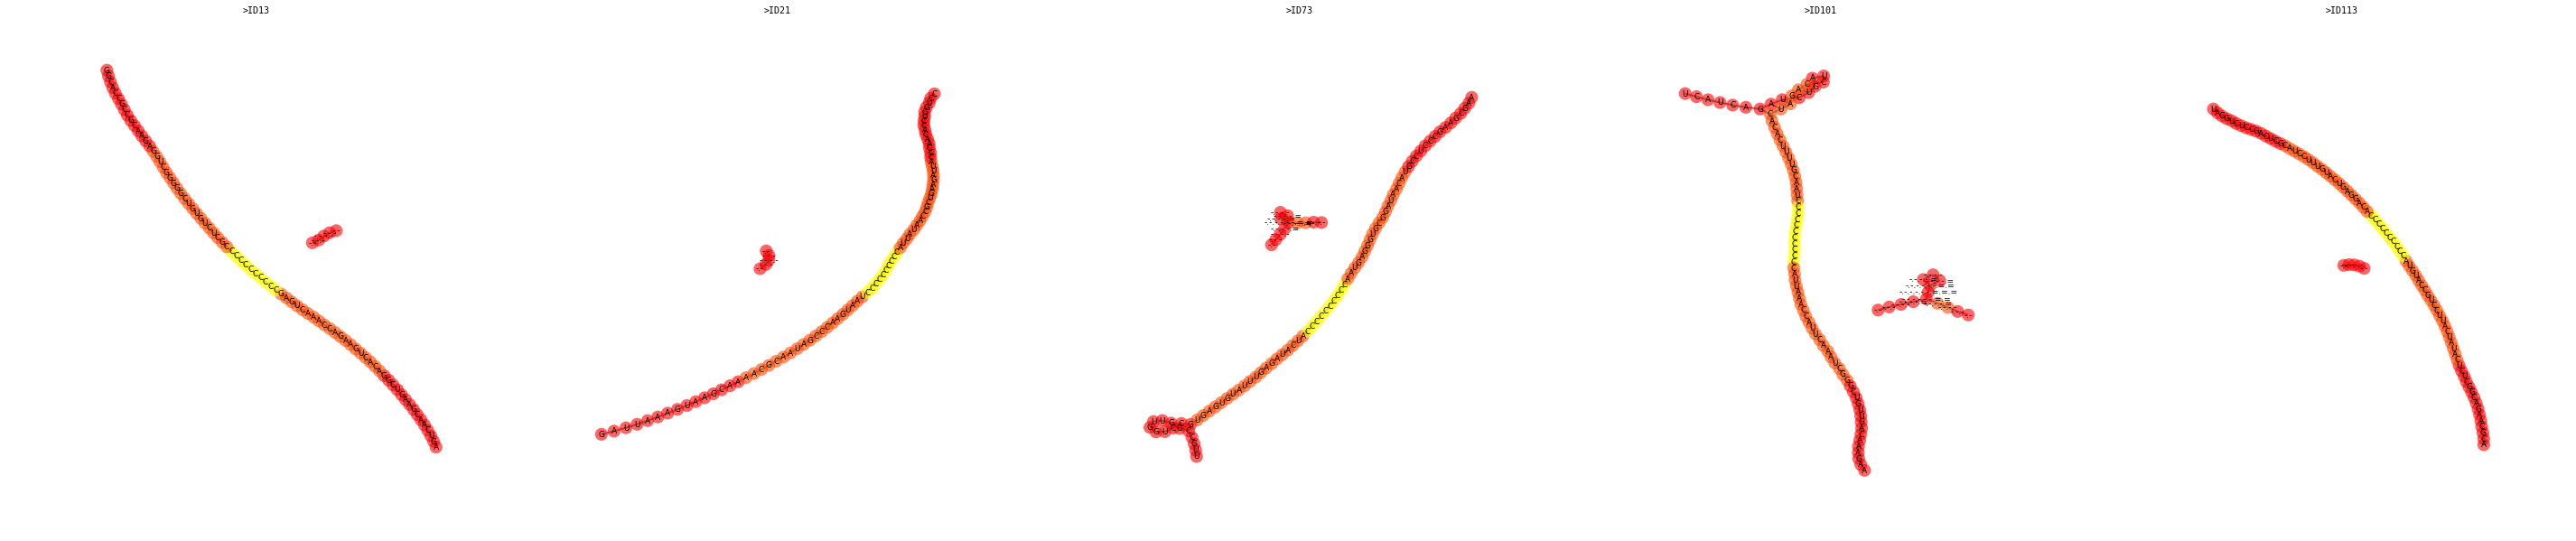

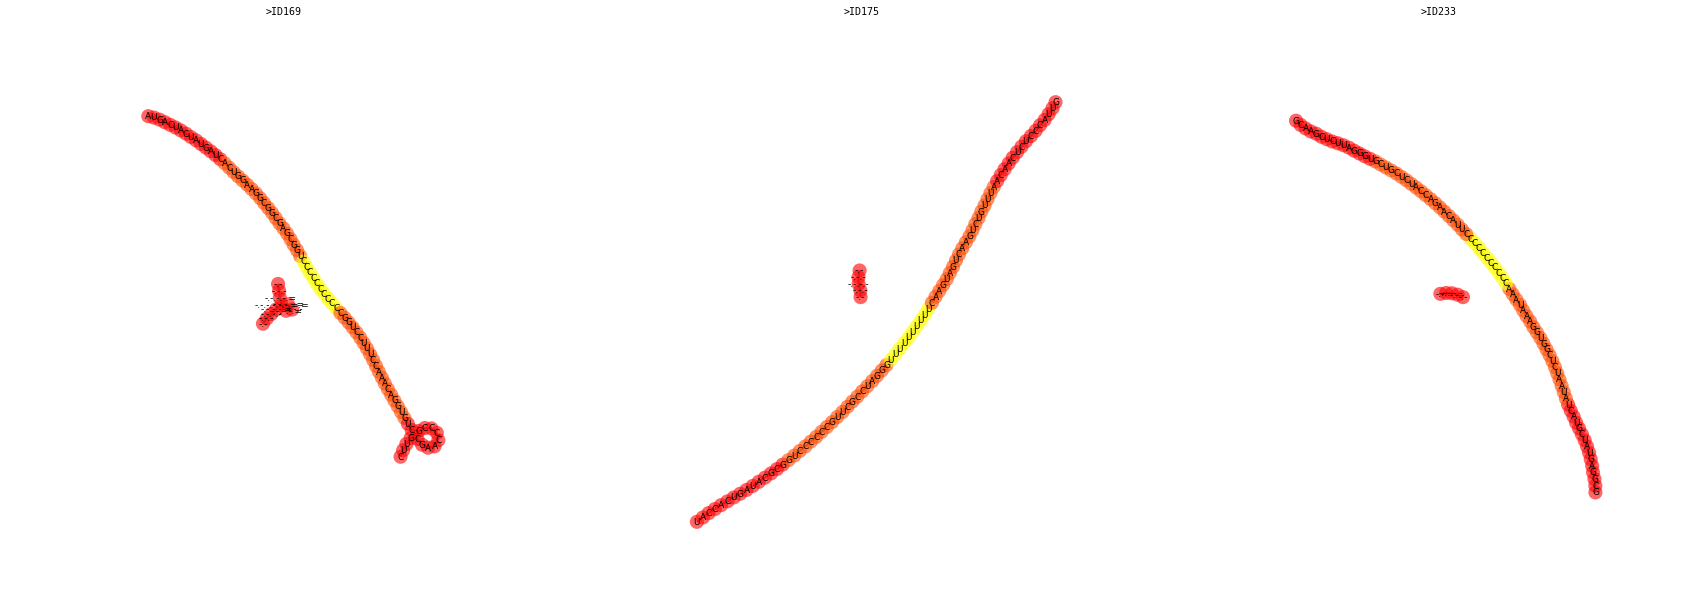

cID: 1 [# 7]
--------------------------------------------------------------------------------


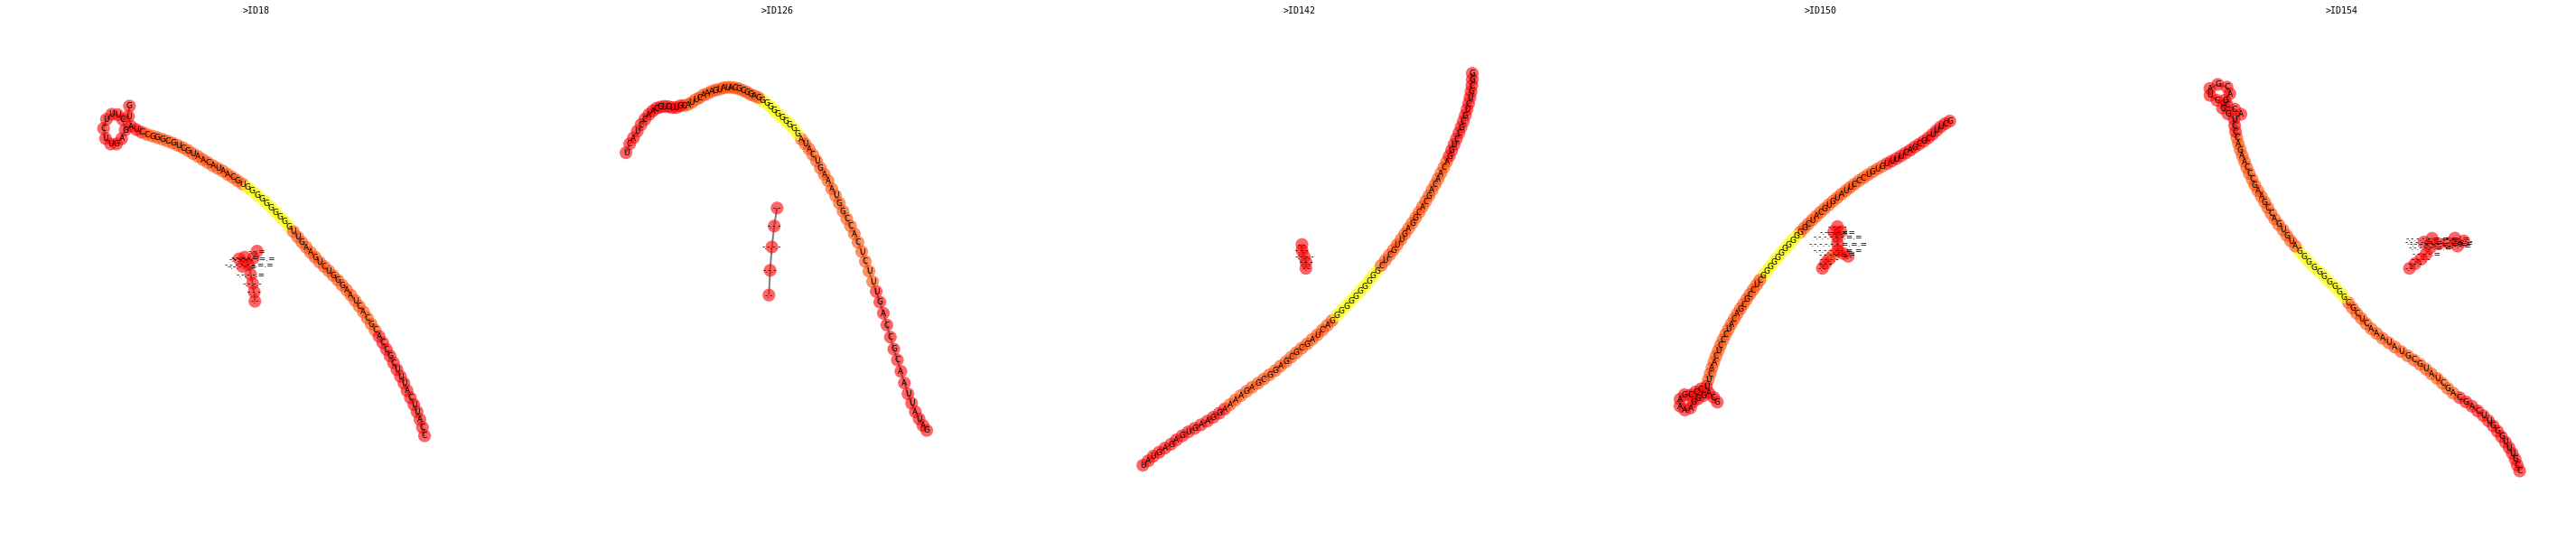

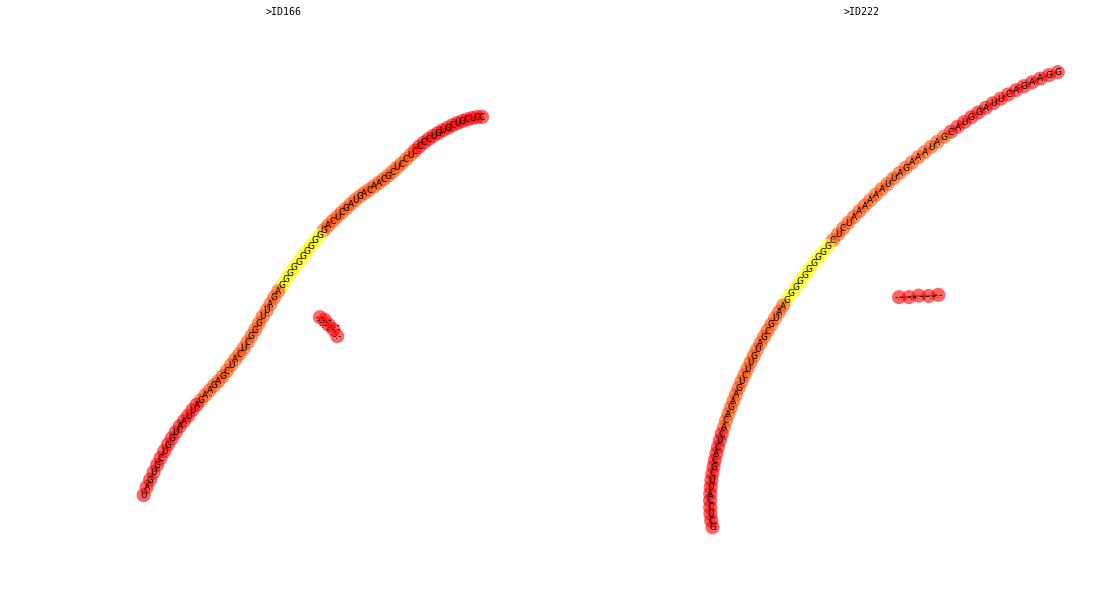

cID: 2 [# 5]
--------------------------------------------------------------------------------


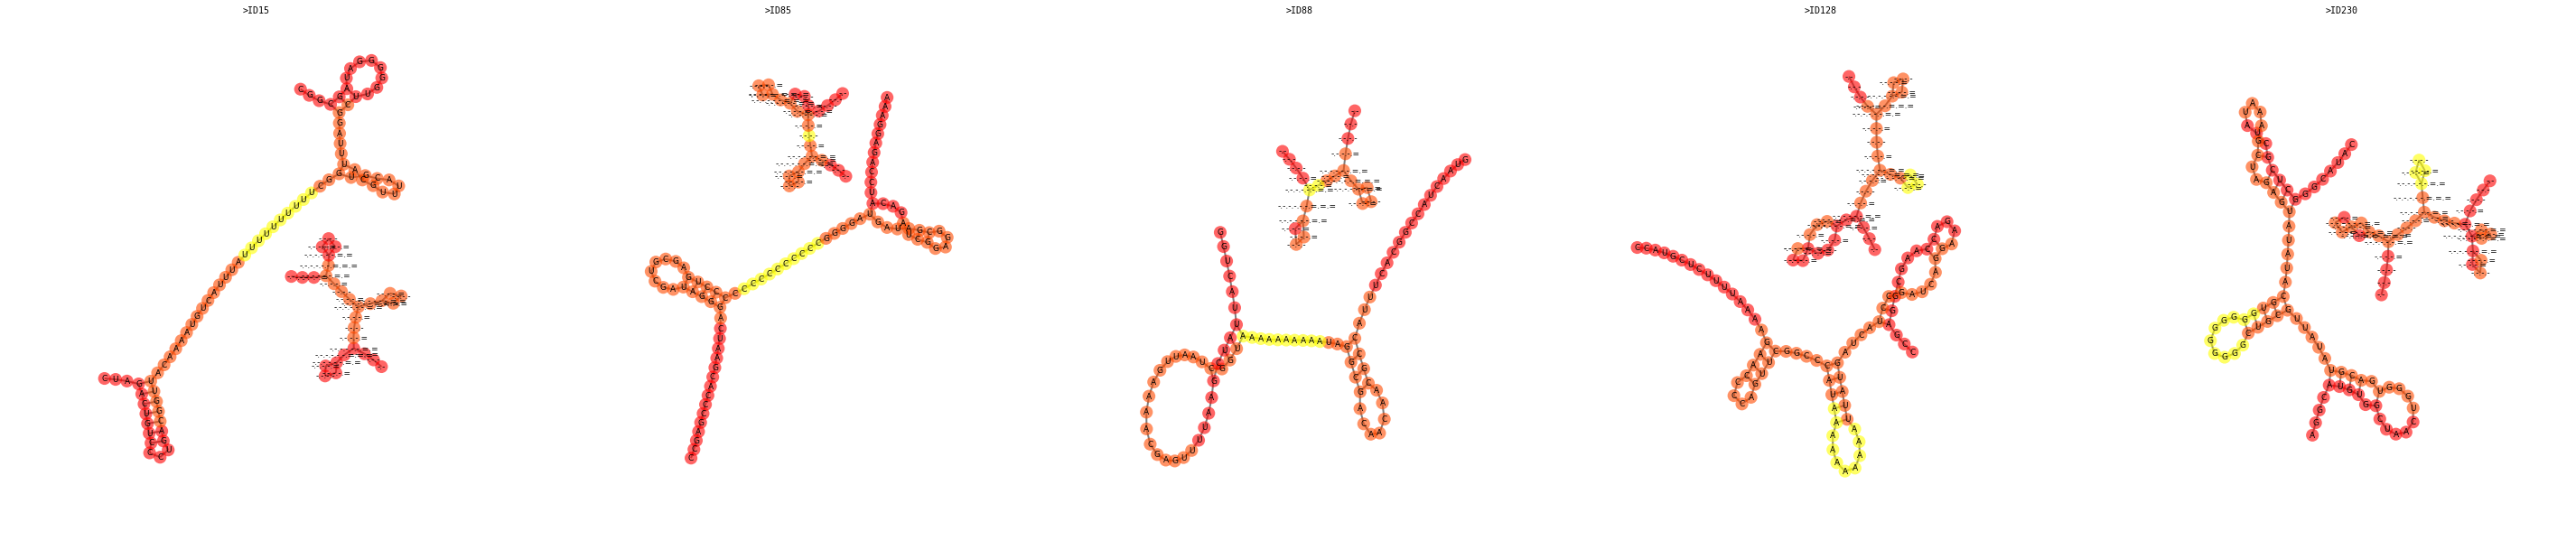

cID: 3 [# 8]
--------------------------------------------------------------------------------


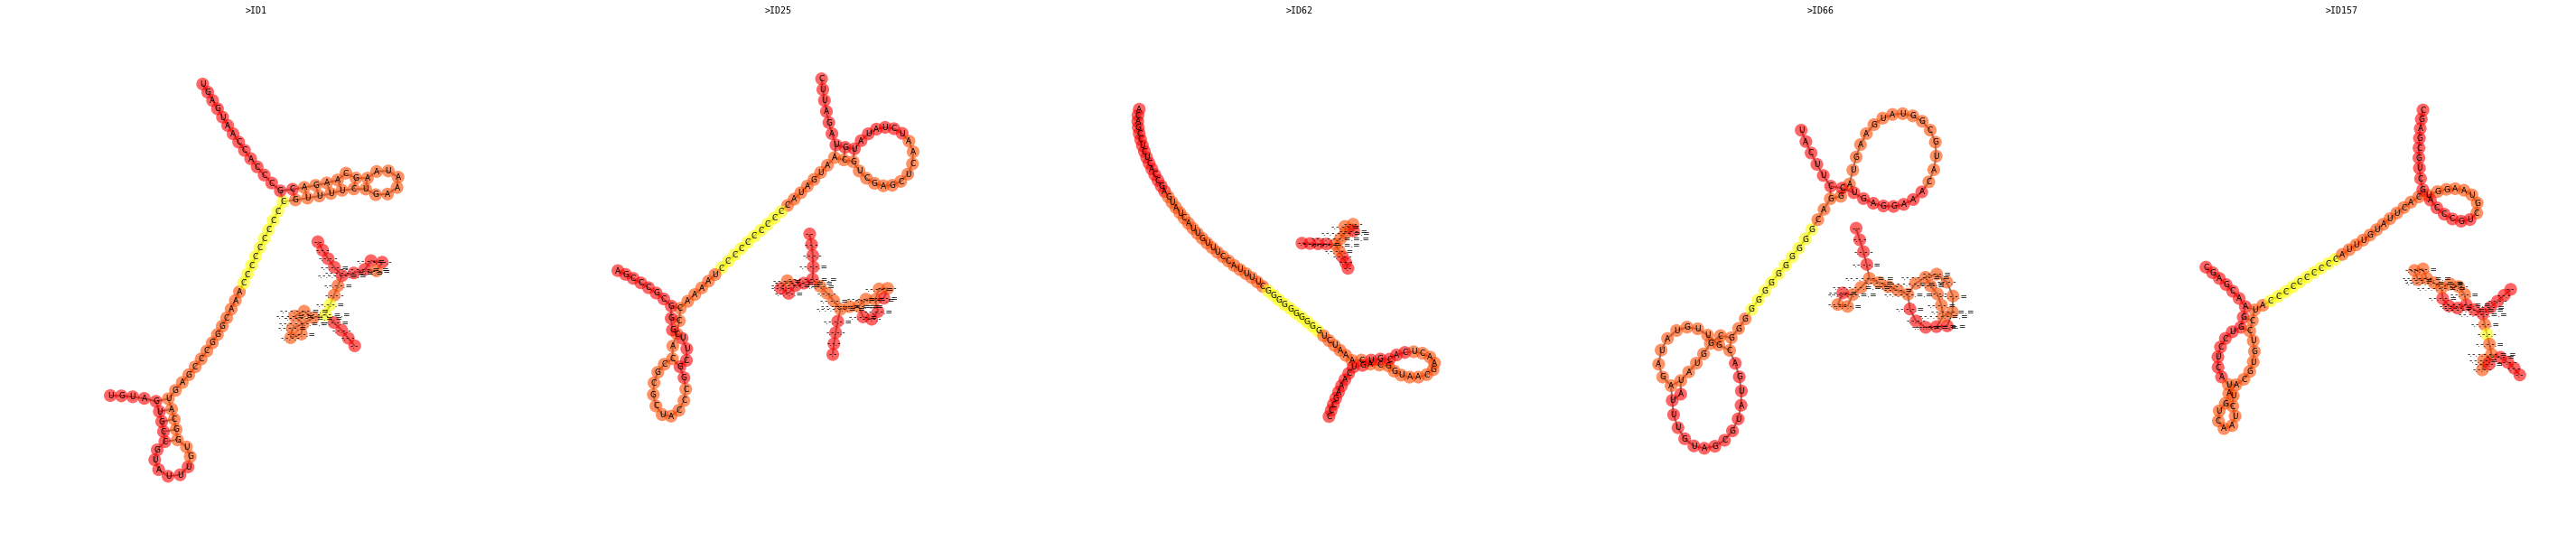

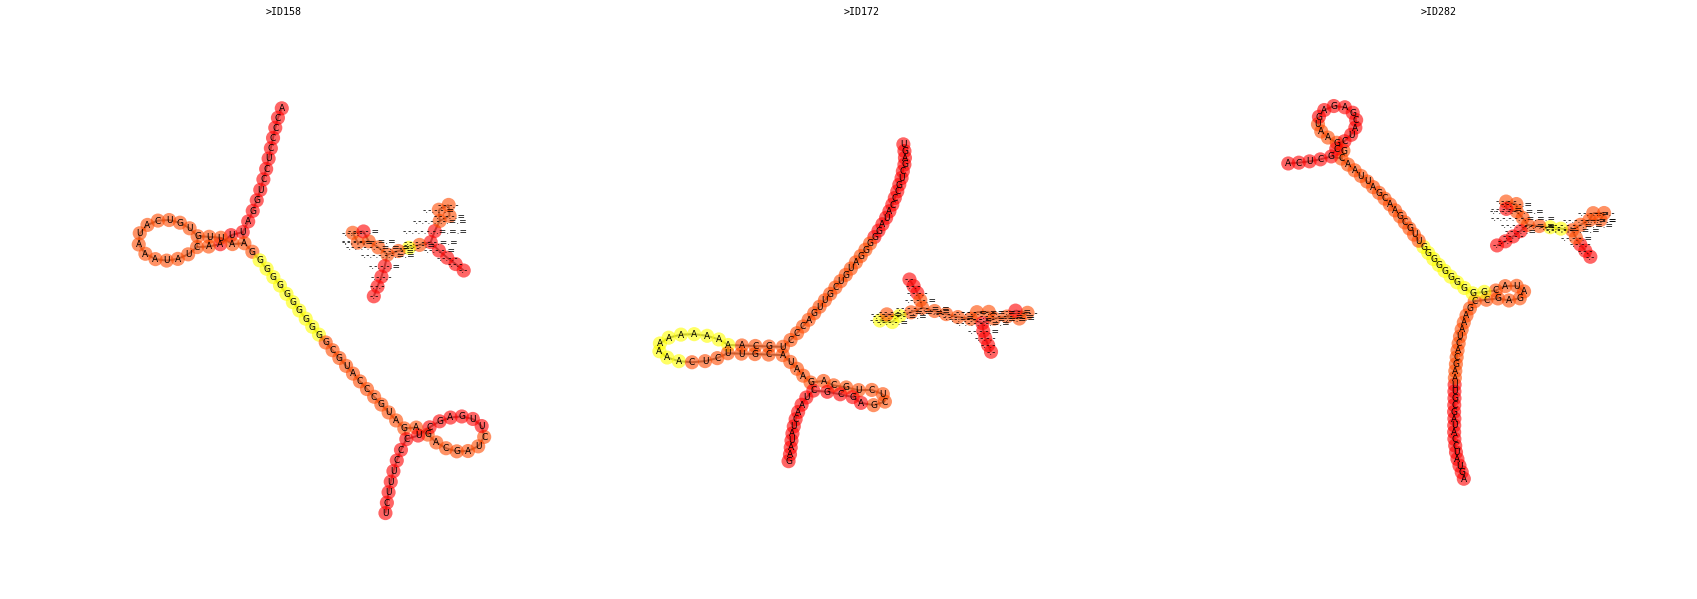

cID: 4 [# 6]
--------------------------------------------------------------------------------


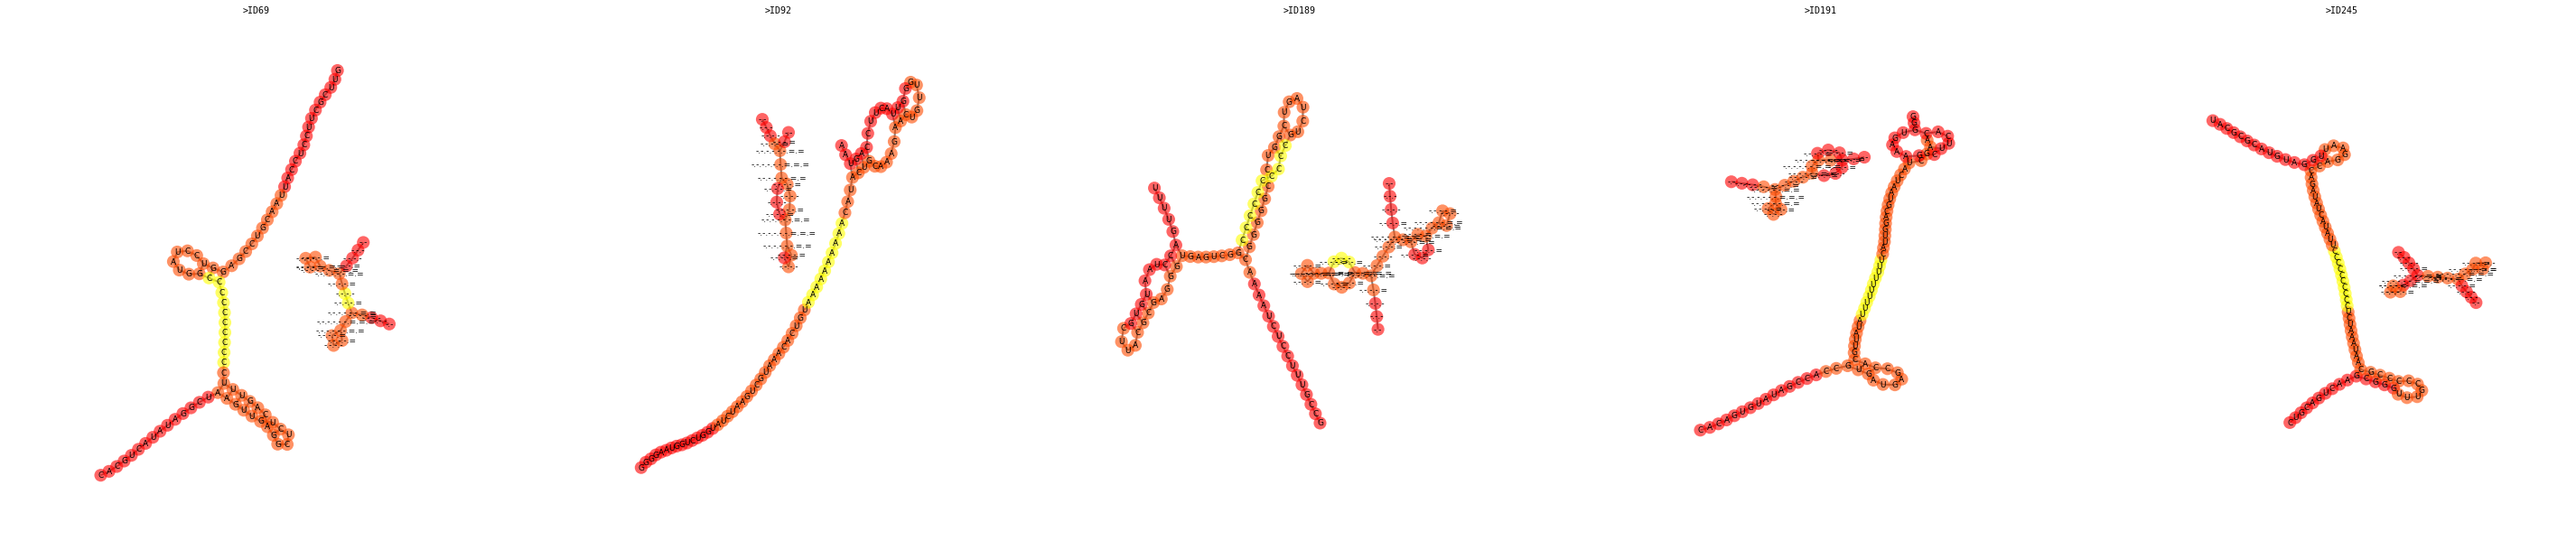

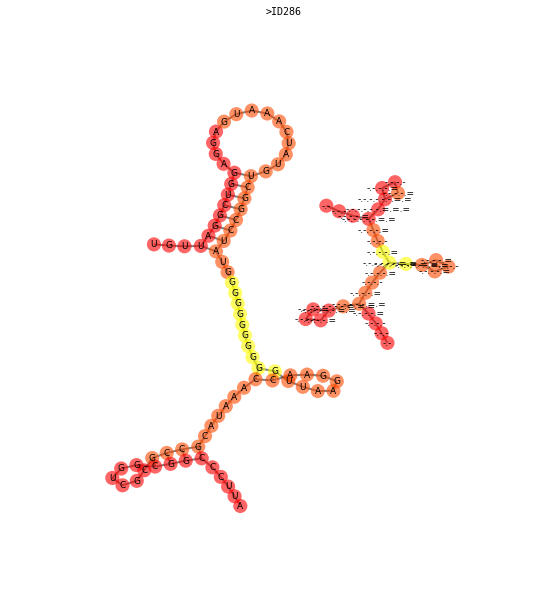

In [31]:
from eden.util.display import draw_graph_set
for cluster_id in clustered_seqs:
    cluster_seqs = [seq for seq in clustered_seqs[cluster_id] ]
    print 'cID: %d [# %d]'% (cluster_id, len(cluster_seqs))
    print '-'*80   
    graphs = transformer.transform(cluster_seqs, listof_start_end_weight_list=listof_start_end_weight_list)
    from eden.modifier.graph.structure import delete_edge_type
    graphs = delete_edge_type(graphs, edge_type_key='nesting')
    my_opt=dict(opts)
    my_opt.update({'size':10, 'vertex_color':'level', 'colormap':'autumn','prog':'neato', 'edge_label':None, 'ignore_for_layout':'nesting'})
    #plot(graphs,opts=my_opt, num=6)
    draw_graph_set(graphs, n_graphs_per_line=5, **my_opt)

---